In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
!pip install keras-tuner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os
import keras_tuner as kt
import keras as k
import argparse
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.3 MB/s eta 0:00:00


In [ ]:
IMG_SIZE = 250

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from PIL import Image
import os
from IPython.display import display
from IPython.display import Image as _Imgdis

print(os.listdir("/gdrive/My Drive/Kidney_Cancer/Kidney Cancer"))

['Normal', 'Tumor']


In [ ]:
DATADIR = '/gdrive/My Drive/Kidney_Cancer/Kidney Cancer'
CATEGORIES = ["Tumor","Normal"]

In [ ]:
all_data =[]

def create_all_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                all_data.append([new_array,class_num])
            except Exception as e:
                pass
create_all_data()

In [ ]:
X = []
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [ ]:
import tensorflow as tf

train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=2)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=2)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow(x_train, train_yCl, batch_size=32)
validation_generator = validation_datagen.flow(x_val, valid_yCl, batch_size=32)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.input

<KerasTensor: shape=(None, 250, 250, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

In [ ]:
from tensorflow import keras
# En iyi performans gösteren modelin ağırlıkları kaydeder.
callback_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        # Sadece en iyi modeli kaydet
        monitor = 'val_accuracy', save_best_only=True, verbose=3
    ),
     # EarlyStopping callback'i, 'val_loss' metriği üzerinde belirtilen sabır süresi (3) boyunca bir iyileşme olmadığında eğitimi durdurur.
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=3)
]

In [ ]:
history_fine_tune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,  # You can adjust the number of epochs
    callbacks=callback_list,
    verbose=3
)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.96250, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30

Epoch 2: val_accuracy did not improve from 0.96250
Epoch 3/30

Epoch 3: val_accuracy improved from 0.96250 to 0.97250, saving model to model.h5
Epoch 4/30

Epoch 4: val_accuracy improved from 0.97250 to 0.99375, saving model to model.h5
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.99375
Epoch 6/30

Epoch 6: val_accuracy did not improve from 0.99375
Epoch 7/30

Epoch 7: val_accuracy improved from 0.99375 to 0.99875, saving model to model.h5
Epoch 8/30

Epoch 8: val_accuracy did not improve from 0.99875
Epoch 9/30

Epoch 9: val_accuracy did not improve from 0.99875
Epoch 10/30

Epoch 10: val_accuracy did not improve from 0.99875
Epoch 10: early stopping


In [ ]:
# Eğitim seti üzerinde modelin performansını değerlendirme
score_train = model.evaluate(x_train, train_yCl)
print("Accuracy: ", score_train[1])

# Test seti üzerinde modelin performansını değerlendirme
score_test = model.evaluate(x_test, test_yCl)
print("Accuracy: ", score_test[1])

# Doğrulama seti üzerinde modelin performansını değerlendirme
score_valid = model.evaluate(x_val, valid_yCl)
print("Accuracy: ", score_valid[1])

225/225 [==============================] - 11s 48ms/step - loss: 28.3673 - accuracy: 0.7654
Accuracy:  0.76541668176651
63/63 [==============================] - 5s 71ms/step - loss: 26.5986 - accuracy: 0.7640
Accuracy:  0.7639999985694885
25/25 [==============================] - 1s 48ms/step - loss: 25.4522 - accuracy: 0.7688
Accuracy:  0.768750011920929


In [ ]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Figür boyutu belirleniyor
    plt.figure(figsize=(3,3))
    # Matris renkli bir görüntüleme ile çiziliyor
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # Grafik başlığı ayarlanıyor
    plt.title(title)
    # Renk skalası ekleniyor
    plt.colorbar()
    # Eksen etiketleri belirleniyor
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # Normalizasyon işlemi kontrol ediliyor
    if normalize:
      # Normalizasyon işlemi
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    # Matris hücrelerine değerleri eklemek için eşleştirme yapılıyor
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    # Eksen etiketleri düzenleniyor
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

63/63 [==============================] - 3s 46ms/step
Accuracy: 0.764
Precision: 0.7640490101864309
Recall: 0.764
F1-Score: 0.7639480548585516
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      1012
           1       0.77      0.75      0.76       988

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



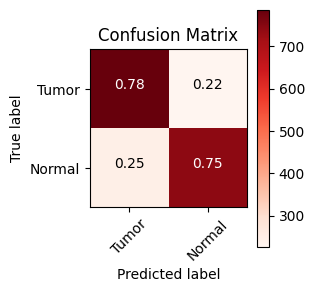

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_model(model, x_test, y_test):
    # Accuracy Score
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(test_yCl, axis=1)
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    print(f"Accuracy: {accuracy}")

    # Precision Score
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    print(f"Precision: {precision}")

    # Recall Score
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    print(f"Recall: {recall}")

    # F1 Score
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    print(f"F1-Score: {f1}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes))

    # Confusion Matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    classes = ["Tumor","Normal"]
    plot_confusion_matrix(cm, classes, title='Confusion Matrix')

# Modeli değerlendir
evaluate_model(model, x_test, y_test)
